In [1]:
import logging
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
import unicodedata
import string
from tqdm import tqdm
from pathlib import Path
from typing import List

import time
import re
from torch.utils.tensorboard import SummaryWriter




logging.basicConfig(level=logging.INFO)

FILE = "../data/en-fra.txt"

writer = SummaryWriter("/tmp/runs/tag-"+time.asctime())

def normalize(s):
    return re.sub(' +',' ', "".join(c if c in string.ascii_letters else " "
         for c in unicodedata.normalize('NFD', s.lower().strip())
         if  c in string.ascii_letters+" "+string.punctuation)).strip()


class Vocabulary:
    """Permet de gérer un vocabulaire.

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    PAD = 0
    EOS = 1
    SOS = 2
    OOVID = 3

    def __init__(self, oov: bool):
        self.oov = oov
        self.id2word = ["PAD", "EOS", "SOS"]
        self.word2id = {"PAD": Vocabulary.PAD, "EOS": Vocabulary.EOS, "SOS": Vocabulary.SOS}
        if oov:
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):
        return len(self.id2word)

    def getword(self, idx: int):
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self, idx: List[int]):
        return [self.getword(i) for i in idx]



class TradDataset():
    def __init__(self,data,vocOrig,vocDest,adding=True,max_len=10):
        self.sentences =[]
        for s in tqdm(data.split("\n")):
            if len(s)<1:continue
            orig,dest=map(normalize,s.split("\t")[:2])
            if len(orig)>max_len: continue
            self.sentences.append((torch.tensor([vocOrig.get(o) for o in orig.split(" ")]+[Vocabulary.EOS]),torch.tensor([vocDest.get(o) for o in dest.split(" ")]+[Vocabulary.EOS])))
    def __len__(self):return len(self.sentences)
    def __getitem__(self,i): return self.sentences[i]



def collate_fn(batch):
    orig,dest = zip(*batch)
    o_len = torch.tensor([len(o) for o in orig])
    d_len = torch.tensor([len(d) for d in dest])
    return pad_sequence(orig),o_len,pad_sequence(dest),d_len


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


with open(FILE) as f:
    lines = f.readlines()

lines = [lines[x] for x in torch.randperm(len(lines))]
idxTrain = int(0.8*len(lines))

vocEng = Vocabulary(True)
vocFra = Vocabulary(True)
MAX_LEN=100
BATCH_SIZE=100

datatrain = TradDataset("".join(lines[:idxTrain]),vocEng,vocFra,max_len=MAX_LEN)
datatest = TradDataset("".join(lines[idxTrain:]),vocEng,vocFra,max_len=MAX_LEN)

train_loader = DataLoader(datatrain, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datatest, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)

#  TODO:  Implémenter l'encodeur, le décodeur et la boucle d'apprentissage


2023-11-19 23:36:37.791604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 23:36:37.930513: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 23:36:39.312904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64::/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64:/opt/gurobi801/linux64/lib
2023-11-19 23:36:39.313304: W tensorflow/stream_executor/platform/de

In [2]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size)
    
    def forward(self, x):
        """
        Input:
            x : tensor 2-D (len, batch)
        Output:
            hn: tensor 3-D (1, batch, hidden_size)
        """
        x_emb = self.emb(x)
        _, hn = self.rnn(x_emb)
        return hn
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size)
        self.lin = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, h):
        """
        Input:
            x : tensor 2-D (len, batch)
        Output:
            hn: tensor 3-D (1, batch, hidden_size)
        """
        x_emb = self.emb(x)
        output, hn = self.rnn(x_emb, h)
        return self.lin(output), hn
    
class translator(nn.Module):
    def __init__(self, vocab_source, vocab_target, emb_size, hidden_size):
        super().__init__()
        self.encoder = Encoder(vocab_source, emb_size, hidden_size)
        self.decoder = Decoder(vocab_target, emb_size, hidden_size)
        
    def forward(self, x_encode, x_decode, sampler = None, iteration=None):
        """
        Input:
            x_encode: tensor 2-D (len, batch)
            x_decode: tensor 2-D (len, batch), start with SOS, shifted right from target
            iteration: None (full teaching force), else i-th mini batch for sampling
        Output:
            y: tensor 3-D (len, batch, vocab_target)
        """
        #x_encode, x_decode = x
        if iteration is None:
            hn = self.encoder(x_encode)
            out, _ = self.decoder(x_decode, hn)
            return out
        else:
            h0_decoder = self.encoder(x_encode)
            res = torch.tensor([]).cuda() # nobody got time for cpu
            input_decode = x_decode[0:1] # (1, batch) contain <SOS> we already reformed x_decode id <sos> ....
            for i in range(len(x_decode)):
                out_lin, h0_decoder =self.decoder(input_decode, h0_decoder) # outlin (1, batch, vocab_out)
                # here sample for EVERY TOKEN as mentioned in the article, sample every sentence would
                # result in consecutive errors
                if sampler(iteration) == 1: # non contraint
                    _, input_decode = out_lin.topk(1) # input_decode (1, batch, 1)
                    input_decode = input_decode.squeeze(-1).detach() # (1, batch)
                else:
                    input_decode = x_decode[i+1:i+2] # next true token
                res = torch.concat([res, out_lin], dim=0) # concatenate along len-axis
            return res # (len_target, batch, vocab_out)
        
    def generate(self, sentence, lenseq=None, vocOrig=vocEng, vocDest=vocFra):
        # transform and add batch dim
        sentence = normalize(sentence)
        x_encode = torch.tensor([vocOrig.get(o) for o in sentence.split(" ")]+[Vocabulary.EOS]).unsqueeze(-1).cuda()
        x_decode = torch.tensor([Vocabulary.SOS]).unsqueeze(-1).cuda()
        # encode
        h0_decoder = self.encoder(x_encode)
        res = torch.tensor([]).cuda()
        # decode
        if lenseq:
            for i in range(lenseq):
                out_lin, h0_decoder =self.decoder(x_decode, h0_decoder) # outlin (1, batch, vocab_out)
                _, x_decode = out_lin.topk(1) # input_decode (1, batch, 1)
                x_decode = x_decode.squeeze(-1).detach() # (1, batch)
                res = torch.concat([res, out_lin], dim=0) # concatenate along len-axis
            res = torch.argmax(torch.softmax(res, dim=-1), dim=-1).permute(1, 0)[0]
            return ' '.join(vocDest.getwords(res))
        else:
            while True:
                out_lin, h0_decoder =self.decoder(x_decode, h0_decoder) # outlin (1, batch, vocab_out)
                _, x_decode = out_lin.topk(1) # input_decode (1, batch, 1)
                x_decode = x_decode.squeeze(-1).detach() # (1, batch)
                res = torch.concat([res, out_lin], dim=0) # concatenate along len-axis
                if torch.argmax(torch.softmax(out_lin, dim=-1), dim=-1).detach().item() == Vocabulary.EOS:
                    break
            res = torch.argmax(torch.softmax(res, dim=-1), dim=-1).permute(1, 0)[0]
            return ' '.join(vocDest.getwords(res[:(res==Vocabulary.EOS).nonzero()[:1].item()]))

https://arxiv.org/pdf/1506.03099.pdf

In [2]:
import numpy as np

class ScheduledSampler:
    """
    Class to choose the learning mode, for the i_th mini-batch
        (teaching force) epsilon_i
        (non-contraint) (1-epsilon_i)
    """
    cfg_decay = {
        'uniform':{
            'begin_step': 50
        },
        'linear':{
            'epsilon': 0.1, # minimum amount of truth
            'k': 1,
            'c': 0.0001
        },
        'exponential': {
            'k': 0.99
        },
        'inv_sigmoid': {
            'k': 100
        }
    }
    
    @staticmethod
    def uniform(i):
        # only begin from begin_step, as the decoder need to learn a bit
        return (torch.rand(1).item() < 0.5)*(i>=cfg_decay['uniform']['begin_step'])
        
    @staticmethod
    def linear(i):
        eps = ScheduledSampler.cfg_decay['linear']['epsilon']
        k = ScheduledSampler.cfg_decay['linear']['k']
        c = ScheduledSampler.cfg_decay['linear']['c']
        eps_i = max(eps, k-c*i)
        return int(torch.rand(1).item() < (1-eps_i))
        
    @staticmethod
    def exponential(i):
        k = ScheduledSampler.cfg_decay['exponential']['k']
        eps_i = k**i
        return int(torch.rand(1).item() < (1-eps_i))
        
    @staticmethod
    def inv_sigmoid(i):
        k = ScheduledSampler.cfg_decay['inv_sigmoid']['k']
        eps_i = k/(k+np.exp(i/k))
        return int(torch.rand(1).item() < (1-eps_i))
    
    @staticmethod
    def set_cfg(cfg):
        ScheduledSampler.cfg_decay = cfg
        
    @staticmethod
    def restore_cfg():
        ScheduledSampler.cfg_decay = {
        'uniform':{
            'begin_step': 50
        },
        'linear':{
            'epsilon': 0.1, # minimum amount of truth
            'k': 1,
            'c': 0.0001
        },
        'exponential': {
            'k': 0.99
        },
        'inv_sigmoid': {
            'k': 100
        }
    }

In [4]:
@torch.no_grad()
def eval_model(dataloader, model, loss_fn, device, sampler = None, iteration=None):
    model.eval()
    loss_test = 0.
    for data in train_loader:
        x_encode, _, y, _ = data
        mini_batch_size = y.shape[1]
        # shift right
        # add SOS to index 0 of each sentence
        x_decode = torch.concat([torch.full((1, mini_batch_size), Vocabulary.SOS), y[:-1, ...]], dim=0)
        # replace EOS by PAD (shifted right)
        x_decode[x_decode == Vocabulary.EOS] = Vocabulary.PAD
        x_encode, x_decode, y = x_encode.to(device), x_decode.to(device), y.to(device)
        # mode in param
        y_hat = model(x_encode, x_decode, sampler, iteration)
        loss = loss_fn(y_hat.permute(0, 2, 1), y)
        loss_test += loss.item()
    model.train()
    return loss_test/len(dataloader)

## Traduction

In [5]:
# HYPER_PARAMS
vocab_source_size = len(vocEng)
vocab_target_size = len(vocFra)
EMB_SIZE = 100
HIDDEN_SIZE = 400
EPOCHS = 5
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = []
dict_plot = {}
# ScheduledSampler
modes_sampling = ['uniform', 'linear', 'exponential', 'inv_sigmoid']
cfg_decay = {
        'uniform':{
            'begin_step': 3000
        },
        'linear':{
            'epsilon': 0.1, # minimum amount of truth
            'k': 1,
            'c': 0.0001
        },
        'exponential': {
            'k': 0.9999
        },
        'inv_sigmoid': {
            'k': 500
        }
    }
ScheduledSampler.set_cfg(cfg_decay)
methods = {
        'uniform': ScheduledSampler.uniform,
        'linear': ScheduledSampler.linear,
        'exponential': ScheduledSampler.exponential,
        'inv_sigmoid': ScheduledSampler.inv_sigmoid
    }
# loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=Vocabulary.PAD)

In [119]:
for sampling_mode in modes_sampling:
    print("Sampling mode:", sampling_mode)
    model = translator(vocab_source_size, vocab_target_size, EMB_SIZE, HIDDEN_SIZE)
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    model.train()
    
    dict_plot[sampling_mode] = {
        'train': [],
        'test': []
    }
    fn_sampling = methods[sampling_mode]
    iteration = 0
    for epoch in tqdm(range(EPOCHS)):
        loss_train = 0
        for data in train_loader:
            x_encode, _, y, _ = data
            mini_batch_size = y.shape[1]
            # shift right
            # add SOS to index 0 of each sentence
            x_decode = torch.concat([torch.full((1, mini_batch_size), Vocabulary.SOS), y[:-1, ...]], dim=0)
            # replace EOS by PAD (shifted right)
            x_decode[x_decode == Vocabulary.EOS] = Vocabulary.PAD
            x_encode, x_decode, y = x_encode.to(device), x_decode.to(device), y.to(device)
            y_hat = model(x_encode, x_decode, fn_sampling, iteration)
            optim.zero_grad()
            loss = loss_fn(y_hat.permute(0, 2, 1), y)
            loss.backward()
            # optim
            optim.step()
            loss_train += loss.item()

            iteration += 1

        dict_plot[sampling_mode]['train'].append(loss_train/len(train_loader))
        # eval
        loss_eval = eval_model(test_loader, model, loss_fn, device, fn_sampling, iteration)
        dict_plot[sampling_mode]['test'].append(loss_eval)
    models.append(model)


Sampling mode: uniform


100%|████████████████████████████████████████████| 5/5 [13:34<00:00, 162.80s/it]


Sampling mode: linear


100%|████████████████████████████████████████████| 5/5 [13:26<00:00, 161.35s/it]


Sampling mode: exponential


100%|████████████████████████████████████████████| 5/5 [13:19<00:00, 159.93s/it]


Sampling mode: inv_sigmoid


100%|████████████████████████████████████████████| 5/5 [13:40<00:00, 164.10s/it]


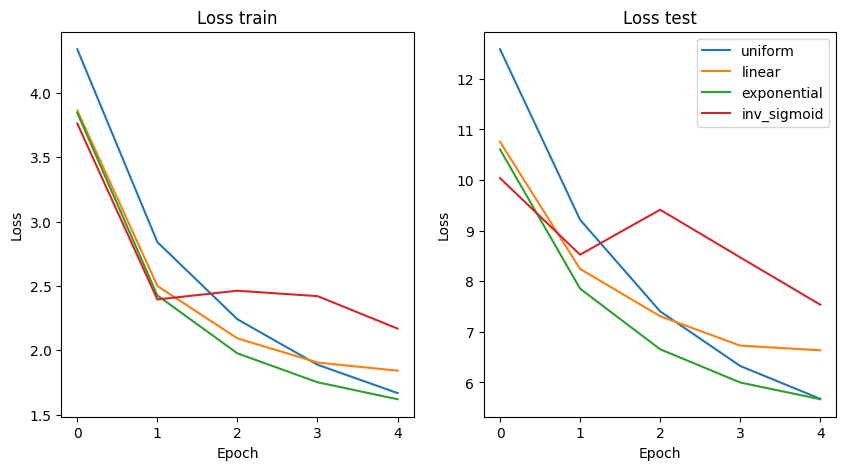

In [130]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()

for sampling_mode in modes_sampling:
    ax[0].plot(dict_plot[sampling_mode]['train'], label=f'{sampling_mode}')
    ax[1].plot(dict_plot[sampling_mode]['test'], label=f'{sampling_mode}')
    
# train
ax[0].title.set_text('Loss train')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
# test
ax[1].title.set_text('Loss test')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.legend()
plt.show()

J'ai fait que 5 epochs comme le temps de calcul est très élevé, pour un meilleur résultat 10-20 epochs serait bon

In [123]:
data = next(iter(test_loader))

In [129]:
nb_visualisation = 5
with torch.no_grad():
    x_encode, _, y, _ = data
    x_encode, y = x_encode.permute(1, 0), y.permute(1, 0) # (batch, len)
    inx_rand = torch.randint(len(x_encode),(nb_visualisation,))
    x_choices = x_encode[inx_rand] # (nb_visualisation, len)
    y_choices = y[inx_rand]
    for i in range(nb_visualisation):
        print(f"Sentence {i}")
        sentence = x_choices[i] # (len,)
        sentence = ' '.join(vocEng.getwords(sentence[:(sentence==Vocabulary.EOS).nonzero()[:1].item()]))
        print("Sentence:", sentence)
        g_truth = y_choices[i] # (len,)
        g_truth = ' '.join(vocFra.getwords(g_truth[:(g_truth==Vocabulary.EOS).nonzero()[:1].item()]))
        print("Ground truth:", g_truth)
        for sampling, m in zip(modes_sampling, models):
            print(f"{sampling}")
            print(m.generate(sentence))
        print("\n")
            
        
    
    
    

Sentence 0
Sentence: this is a bit embarrassing
Ground truth: c est un peu embarrassant
uniform
c est un peu convaincant
linear
c est un peu de
exponential
c est un embarrassant
inv_sigmoid
c est un peu


Sentence 1
Sentence: what s all the hubbub about
Ground truth: qu est tout ce brouhaha
uniform
qu est ce qui bohu a de tout
linear
qu est ce que tout le monde est
exponential
tout ce que c est a propos de notre
inv_sigmoid
qu est quoi t il de


Sentence 2
Sentence: why do i tell you people anything
Ground truth: pourquoi est ce que je vous cause d abord
uniform
pourquoi dis je que tu dis a quelque chose
linear
pourquoi me ce que je que je les gens
exponential
pourquoi dis ce que tu dis que tu dis
inv_sigmoid
pourquoi ne dis que je que dire cela


Sentence 3
Sentence: i don t know what you re looking for
Ground truth: je ne sais pas ce que vous cherchez
uniform
j ignore ce que tu cherches
linear
je ignore ce que tu cherches
exponential
je ne sais pas ce que tu cherches
inv_sigmoid
je n

En général, pour cette configuration, le scheduler sampling exponential converge plus rapide que d'autres, conduisant un meilleur résultat généré.

## Segmentation efficace d'un texte

Vocabulaire partagé ! Un Vocabulaire pour 2 langues (Table 1). On n'a pas besoin de normalizer les mots non plus (3.4). https://arxiv.org/pdf/1808.06226.pdf

In [46]:
import sentencepiece as spm

MODEL_OUTPUT_PATH = 'spmModel'
vocab_size = 1000
user_defined_symbols = []
rules = f'--input={FILE} --vocab_size={vocab_size} --model_prefix={MODEL_OUTPUT_PATH} --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]'

In [47]:
spm.SentencePieceTrainer.train(rule)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=../data/en-fra.txt --vocab_size=1000 --model_prefix=spmModel --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../data/en-fra.txt
  input_format: 
  model_prefix: spmModel
  model_type: UNIGRAM
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_v

Segmenter une phrase

In [6]:
import sentencepiece as spm

vocab_size = 1000
MODEL_OUTPUT_PATH = 'spmModel'
s = spm.SentencePieceProcessor(model_file = MODEL_OUTPUT_PATH+'.model')

# English
print("EN")
ids = s.encode('Hello guys!', out_type=int)
print(ids)
print(s.decode(ids))
print(s.encode('Hello guys!', out_type=str))

# French
print("FR")
ids = s.encode('Comment allez-vous?', out_type=int)
print(ids)
print(s.decode(ids))
print(s.encode('Comment allez-vous?', out_type=str))

EN
[147, 105, 38, 366, 54, 40, 9, 677]
Hello guys!
['▁He', 'll', 'o', '▁g', 'u', 'y', 's', '!']
FR
[646, 24, 230, 179, 8, 168, 45]
Comment allez-vous?
['▁Commen', 't', '▁all', 'ez', '-', 'vous', '?']


In [7]:
class TradDataset_SMP():
    def __init__(self,data,sentenceProcessor,adding=True,max_len=10):
        self.sentences =[]
        for s in tqdm(data.split("\n")):
            if len(s)<1:continue
            orig,dest = s.split("\t")[:2]
            if len(orig)>max_len: continue
            orig = sentenceProcessor.encode(orig, out_type=int)
            dest = sentenceProcessor.encode(dest, out_type=int)
            # ajouter bos à y: bos ... eos
            self.sentences.append((torch.tensor(orig+[sentenceProcessor.eos_id()]),\
                                   torch.tensor([sentenceProcessor.bos_id()]+dest+[sentenceProcessor.eos_id()])))
    def __len__(self):return len(self.sentences)
    def __getitem__(self,i): return self.sentences[i]



def collate_fn_spm(batch, pad_id):
    orig,dest = zip(*batch)
    o_len = torch.tensor([len(o) for o in orig])
    d_len = torch.tensor([len(d) for d in dest])
    # par df pad dans spm -1
    return pad_sequence(orig, padding_value=pad_id),o_len,pad_sequence(dest, padding_value=pad_id),d_len


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


with open(FILE) as f:
    lines = f.readlines()

lines = [lines[x] for x in torch.randperm(len(lines))]
idxTrain = int(0.8*len(lines))

vocEng = Vocabulary(True)
vocFra = Vocabulary(True)
MAX_LEN=100
BATCH_SIZE=100

Je crée un autre traducteur, qui n'a que 1 couche embedding pour encodeur et décodeur comme la langue source et la langue cible partagent le vocab

In [11]:
class Encoder_2(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.rnn = nn.GRU(emb_size, hidden_size)
    
    def forward(self, x):
        """
        Input:
            x : tensor 2-D (len, batch, emb)
        Output:
            hn: tensor 3-D (1, batch, hidden_size)
        """
        _, hn = self.rnn(x)
        return hn
    
class Decoder_2(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.rnn = nn.GRU(emb_size, hidden_size)
        self.lin = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, h):
        """
        Input:
            x : tensor 2-D (len, batch, emb)
        Output:
            hn: tensor 3-D (1, batch, hidden_size)
        """
        output, hn = self.rnn(x, h)
        return self.lin(output), hn
    
class translator_2(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.encoder = Encoder_2(emb_size, hidden_size)
        self.decoder = Decoder_2(vocab_size, emb_size, hidden_size)
        
    def forward(self, x_encode, x_decode, sampler = None, iteration=None):
        """
        Input:
            x_encode: tensor 2-D (len, batch)
            x_decode: tensor 2-D (len, batch), start with SOS, shifted right from target
            iteration: None (full teaching force), else i-th mini batch for sampling
        Output:
            y: tensor 3-D (len, batch, vocab_target)
        """
        x_encode, x_decode = self.emb(x_encode), self.emb(x_decode)
        if iteration is None:
            hn = self.encoder(x_encode)
            out, _ = self.decoder(x_decode, hn)
            return out
        else:
            h0_decoder = self.encoder(x_encode)
            res = torch.tensor([]).cuda() # nobody got time for cpu
            input_decode = x_decode[0:1] # (1, batch) contain <SOS> we already reformed x_decode id <sos> ....
            for i in range(len(x_decode)):
                out_lin, h0_decoder =self.decoder(input_decode, h0_decoder) # outlin (1, batch, vocab_out)
                # here sample for EVERY TOKEN as mentioned in the article, sample every sentence would
                # result in consecutive errors
                if sampler(iteration) == 1: # non contraint
                    _, input_decode = out_lin.topk(1) # input_decode (1, batch, 1)
                    input_decode = input_decode.squeeze(-1).detach() # (1, batch)
                    input_decode = self.emb(input_decode) # (1, batch, emb)
                else:
                    input_decode = x_decode[i+1:i+2] # next true token
                res = torch.concat([res, out_lin], dim=0) # concatenate along len-axis
            return res # (len_target, batch, vocab_out)
        
    def generate(self, sentence, s_processor, lenseq=None):
        """
        sentence: (l,b)
        """
        # transform and add batch dim
        x_encode = self.emb(sentence)
        x_decode = torch.tensor([s_processor.bos_id()]).unsqueeze(-1).cuda()
        x_decode = self.emb(x_decode)
        # encode
        h0_decoder = self.encoder(x_encode)
        res = torch.tensor([]).cuda()
        # decode
        if lenseq:
            for i in range(lenseq):
                out_lin, h0_decoder =self.decoder(x_decode, h0_decoder) # outlin (1, batch, vocab_out)
                _, x_decode = out_lin.topk(1) # input_decode (1, batch, 1)
                x_decode = x_decode.squeeze(-1).detach() # (1, batch)
                x_decode = self.emb(x_decode) # (1, batch, emb)
                res = torch.concat([res, out_lin], dim=0) # concatenate along len-axis
            res = torch.argmax(torch.softmax(res, dim=-1), dim=-1).permute(1, 0)[0].detach().tolist()

            return s.decode(res)
        else:
            while True:
                out_lin, h0_decoder =self.decoder(x_decode, h0_decoder) # outlin (1, batch, vocab_out)
                _, x_decode = out_lin.topk(1) # input_decode (1, batch, 1)
                x_decode = x_decode.squeeze(-1).detach() # (1, batch)
                x_decode = self.emb(x_decode)
                res = torch.concat([res, out_lin], dim=0) # concatenate along len-axis
                if torch.argmax(torch.softmax(out_lin, dim=-1), dim=-1).detach().item() == Vocabulary.EOS:
                    break
            res = torch.argmax(torch.softmax(res, dim=-1), dim=-1).permute(1, 0)[0]
            return s.decode(res[:(res==s_processor.eos_id()).nonzero()[:1].item()].detach().tolist())

In [8]:
@torch.no_grad()
def eval_model(dataloader, model, loss_fn, device, seg=None, sampler = None, iteration=None):
    """
        seg: segmentation ou pas
    """
    model.eval()
    loss_test = 0.
    for data in train_loader:
        x_encode, _, y, _ = data
        mini_batch_size = y.shape[1]
        if not seg:
            # shift right
            # add SOS to index 0 of each sentence
            x_decode = torch.concat([torch.full((1, mini_batch_size), Vocabulary.SOS), y[:-1, ...]], dim=0)
            # replace EOS by PAD (shifted right)
            x_decode[x_decode == Vocabulary.EOS] = Vocabulary.PAD
        else:
            x_decode = y[:-1, ...] # enlever dernier token - eos
            x_decode[x_decode == seg.eos_id()] = seg.pad_id()
            y = y[1:, ...] # enlever premier token - bos
        x_encode, x_decode, y = x_encode.to(device), x_decode.to(device), y.to(device)
        # mode in param
        y_hat = model(x_encode, x_decode, sampler, iteration)
        loss = loss_fn(y_hat.permute(0, 2, 1), y)
        loss_test += loss.item()
    model.train()
    return loss_test/len(dataloader)

In [28]:
# HYPER_PARAMS
vocab_source_size = len(vocEng)
vocab_target_size = len(vocFra)
vocab_size = 1000
EMB_SIZE = 100
HIDDEN_SIZE = 400
EPOCHS = 200
LR = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = []
dict_plot = {}
# ScheduledSampler
modes_sampling = ['uniform', 'linear', 'exponential', 'inv_sigmoid']
cfg_decay = {
        'uniform':{
            'begin_step': 3000
        },
        'linear':{
            'epsilon': 0.1, # minimum amount of truth
            'k': 1,
            'c': 0.0001
        },
        'exponential': {
            'k': 0.9999
        },
        'inv_sigmoid': {
            'k': 500
        }
    }
ScheduledSampler.set_cfg(cfg_decay)
methods = {
        'uniform': ScheduledSampler.uniform,
        'linear': ScheduledSampler.linear,
        'exponential': ScheduledSampler.exponential,
        'inv_sigmoid': ScheduledSampler.inv_sigmoid
    }
datatrain = TradDataset_SMP("".join(lines[:idxTrain]),s,max_len=MAX_LEN)
datatest = TradDataset_SMP("".join(lines[idxTrain:]),s,max_len=MAX_LEN)
# afin de comparer -> pas de shuffle
train_loader = DataLoader(datatrain, collate_fn=lambda x: collate_fn_spm(x, s.pad_id()),\
                                  batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datatest, collate_fn=lambda x: collate_fn_spm(x, s.pad_id()),\
                                 batch_size=BATCH_SIZE, shuffle=True)
# loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=s.pad_id())

100%|██████████████████████████████████| 34132/34132 [00:01<00:00, 27399.48it/s]


In [29]:
from pathlib import Path

class State:
    def __init__(self, model, optim):
        self.model = model
        self.optim = optim
        self.epoch = 0
        self.iteration = 0
        self.loss_train = []
        self.loss_test = []
        
savepath = Path('seg.plt')

In [30]:
if savepath.is_file():
    with savepath.open("rb") as fp :
        state = torch.load(fp)
else:
    model = translator_2(vocab_size, EMB_SIZE, HIDDEN_SIZE).to(device)
    optim = torch.optim.Adam(params=model.parameters(),lr=LR)
    state = State(model, optim)
    
state.model.train()
    

sampling_mode = 'exponential'
seg_modes = ['segmentation']
seg_mode = seg_modes[0]
print("Mode:", seg_mode)
fn_sampling = methods[sampling_mode]

for epoch in tqdm(range(state.epoch, EPOCHS)):
    loss_train = 0
    for data in train_loader:
        x_encode, _, y, _ = data
        mini_batch_size = y.shape[1]
        # ici, y a BOS
        x_decode = y[:-1, ...] # enlever dernier token - eos
        x_decode[x_decode == s.eos_id()] = s.pad_id()
        y = y[1:, ...] # enlever premier token - bos
        x_encode, x_decode, y = x_encode.to(device), x_decode.to(device), y.to(device)
        y_hat = state.model(x_encode, x_decode, fn_sampling, state.iteration)
        state.optim.zero_grad()
        loss = loss_fn(y_hat.permute(0, 2, 1), y)
        loss.backward()
        # optim
        state.optim.step()
        loss_train += loss.item()

        state.iteration += 1
        
    state.loss_train.append(loss_train/len(train_loader))
    # evals
    loss_eval = eval_model(test_loader, state.model, loss_fn, device, s, fn_sampling, state.iteration)
    state.loss_test.append(loss_eval)
    with savepath.open("wb") as fp :
        state.epoch = epoch + 1
        torch.save(state, fp)

Mode: segmentation


100%|███████████████████████████████████████| 200/200 [2:37:24<00:00, 47.22s/it]


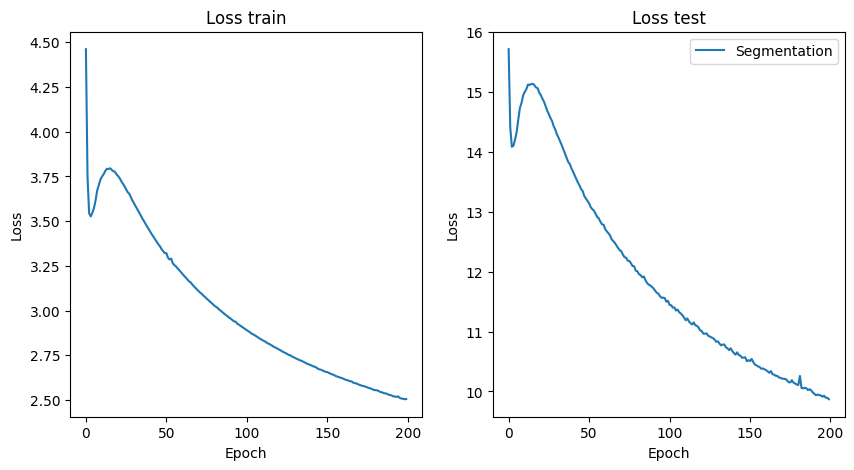

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()


ax[0].plot(state.loss_train, label='Segmentation')
ax[1].plot(state.loss_test, label='Segmentation')
    
# train
ax[0].title.set_text('Loss train')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
# test
ax[1].title.set_text('Loss test')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.legend()
plt.show()

In [38]:
data = next(iter(test_loader))
nb_visualisation = 5
with torch.no_grad():
    x_encode, _, y, _ = data
    x_encode, y = x_encode.permute(1, 0), y.permute(1, 0) # (batch, len)
    inx_rand = torch.randint(len(x_encode),(nb_visualisation,))
    x_choices = x_encode[inx_rand] # (nb_visualisation, len)
    y_choices = y[inx_rand]
    for i in range(nb_visualisation):
        print(f"Sentence {i}")
        sentence_ori = x_choices[i] # (len,)
        
        sentence = s.decode(sentence_ori.tolist())
        print("Sentence:", sentence)
        g_truth = y_choices[i] # (len,)
        g_truth = s.decode(g_truth.tolist())
        print("Ground truth:", g_truth)
        print("Pred:",state.model.generate(sentence_ori.reshape((-1, 1)).cuda(), s, 20))
        print("\n")

Sentence 0
Sentence: How many students have been admitted to the school this year?
Ground truth: Combien d'étudiants ont été admis à l'école cette année ?
Pred: Combien d' ass a -- silsssss


Sentence 1
Sentence: You're clever.
Ground truth: Tu es maline.
Pred: Vous êtes malin................


Sentence 2
Sentence: You told me that you were tired.
Ground truth: Vous m'avez dit que vous étiez fatigué.
Pred: Tu m'avez dit que vous étiez fatiguée...


Sentence 3
Sentence: You're very talented.
Ground truth: Tu es fort talentueux.
Pred: Vous êtes fortttalalue..........


Sentence 4
Sentence: Everybody will be tired.
Ground truth: Tout le monde sera fatigué.
Pred: Tout le monde se ttt.........yy.




Convergence is pretty slow, need to do hyper-parameters search to find a set of optimal hyper-parameters